In [142]:
## Library imports
import os
from utils import select_files, create_directory, getclosest_ij
from helper import create_fieldset, create_particleset, create_kernel, load_default_settings, load_test_settings
from parcels import ParticleFile
#from plotting import plot_release_locations
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np

In [143]:
os.getcwd()

'/Users/denes001/Research/Projects/PlasticParcels/PlasticParcels/src/trajectory'

# User options
TODO: Write a description here

In [144]:
## User options
testing_version = 'local'
if testing_version == 'local':
    user_settings = {'user': 'denes001',
                    'output_directory': '../../data/output_data/',
                    'fig_directory': '../../fig/',
                    }
else:
    user_settings = {'user': 'denes001',
                    'output_directory': '/storage/shared/oceanparcels/output_data/data_Michael/PlasticTransportKernels/data/output_data/',
                    'fig_directory': '/storage/shared/oceanparcels/output_data/data_Michael/PlasticTransportKernels/fig/',
                    }

## Create directories if missing
create_directory(user_settings['output_directory'])
create_directory(user_settings['fig_directory'])

# Model settings
TODO: Write a description here

In [145]:
## Model settings
model_settings, particle_settings = load_test_settings()

In [146]:
fieldset = create_fieldset(model_settings, particle_settings)

In [147]:
particle_settings

{'start_date': datetime.datetime(2019, 1, 10, 0, 0),
 'runtime': datetime.timedelta(days=3),
 'dt_write': datetime.timedelta(days=1),
 'dt_timestep': datetime.timedelta(seconds=1200)}

In [148]:
import pandas as pd
from parcels import Variable, JITParticle, ParticleSet
def create_particleset_from_file(fieldset, particle_settings):
    """ Helper function to create a Parcels.ParicleSet

    Parameters
    ----------
    model_settings :
        A dictionary of model settings used to create the fieldset
    particle_settings :
        A dictionary of particle settings used to define some ....

    Returns
    -------
    fieldset
        A parcels.FieldSet object
    """

    # Load release type information
    release_type = particle_settings['release_type']
    if release_type == 'coastal':
        release_file = '../../data/release/generated_files/coastal_population_MPW_NEMO0083.csv'
        release_quantity_name = 'MPW_Cell'
    elif release_type == 'rivers':
        release_file = '../../data/release/generated_files/river_emissions_NEMO0083.csv'
        release_quantity_name = 'Emissions'
    elif release_type == 'fisheries':
        release_file = '../../data/release/generated_files/agg_data_fisheries_info.csv'
        release_quantity_name = 'fishing_hours'
    
    particle_locations = pd.read_csv(release_file)
    
    
    # Select specific continent/region/subregion/country/economic status if applicable:
    if 'continent' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Continent'] == particle_settings['continent']]
    if 'region' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Region'] == particle_settings['region']]
    if 'subregion' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Subregion'] == particle_settings['subregion']]
    if 'country' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Country'] == particle_settings['country']]
    if 'economicstatus' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Economic status'] == particle_settings['economicstatus']]
    
    particle_locations = particle_locations.groupby(['Longitude', 'Latitude'])[release_quantity_name].agg('sum').reset_index()
    particle_locations = particle_locations[particle_locations[release_quantity_name]>0]

    depths = None
    times = None
    if 'depths' in particle_settings.keys():
        depths = particle_settings['depths']
    if type(depths) == float:
        depths = np.full(len(particle_locations), depths)

    if 'times' in particle_settings.keys():
        times = particle_settings['times']
    if type(times) == float:
        times = np.full(len(particle_locations), times)


    ## Set particle densities 
    if type(particle_settings['particle_density']) == float:
        particle_densities = np.full(len(particle_locations), particle_settings['particle_density'])
    else:
        particle_densities = particle_settings['particle_density']

    ## Set particle lengths
    if type(particle_settings['particle_diameter']) == float:
        particle_diameters = np.full(len(particle_locations), particle_settings['particle_diameter'])
    else:
        particle_diameters = particle_settings['particle_diameter']


    ## Set wind coefficients of particles
    if 'windage_coefficient' in particle_settings.keys():
        if type(particle_settings['windage_coefficient']) == float:
            windage_coefficients = np.full(len(particle_locations), particle_settings['windage_coefficient'])
        else:
            windage_coefficients = particle_settings['windage_coefficient'] # Assumed to be an array of coefficients


    ## Add variables to particle based on fieldset flags
    to_write_tracer = False
    to_write_dynamic = False
    to_write_all = False
    if 'write_output_option' not in particle_settings.keys():
        pass
    elif particle_settings['write_output_option'] == 'none':
        pass
    elif particle_settings['write_output_option'] == 'tracer':
        to_write_tracer = True
    elif particle_settings['write_output_option'] == 'dynamic':
        to_write_tracer = True
        to_write_dynamic = True
    elif particle_settings['write_output_option'] == 'all':
        to_write_tracer = True
        to_write_dynamic = True
        to_write_all = True

    ## Add variables to particle based on fieldset flags
    variables = []
    variables.append(Variable('particle_diameter', dtype=np.float32, to_write=to_write_all))                   # Particle Diameter (assuming spherical particle) [meters] (l_pl)
    variables.append(Variable('particle_density', dtype=np.float32, to_write=to_write_all))                            # Particle Density [kg/m^3] (rho_pl)
    variables.append(Variable('settling_velocity', dtype=np.float64, initial=0., to_write=to_write_dynamic))              # Particle Sinking Velocity [m/s] (v_s)
    variables.append(Variable('seawater_density', dtype=np.float32, to_write=to_write_dynamic))
    variables.append(Variable('absolute_salinity', dtype=np.float64, to_write=to_write_dynamic))
    variables.append(Variable('windage_coefficient', dtype=np.float32, initial=0., to_write=to_write_all))
    variables.append(Variable('algae_amount', dtype=np.float64, initial=0., to_write=to_write_dynamic))

    # Create PlasticParticle class
    PlasticParticle = JITParticle
    for variable in variables:
        setattr(PlasticParticle, variable.name, variable)

    # Add kernel specific variables
    # TODO
    #if fieldset.biofouling_f:
    #if fieldset.wind_f:
        
    

    ## Create the particle set
    if not fieldset.wind_f:
        pset = ParticleSet.from_list(fieldset,
                                    PlasticParticle,
                                    lon=particle_locations['Longitude'],
                                    lat=particle_locations['Latitude'],
                                    time=times,
                                    depth=depths,
                                    particle_diameter=particle_diameters,
                                    particle_density=particle_densities
                                    )
    else:
        pset = ParticleSet.from_list(fieldset,
                                    PlasticParticle,
                                    lon=particle_locations['Longitude'],
                                    lat=particle_locations['Latitude'],
                                    time=times,
                                    depth=depths,
                                    particle_diameter=particle_diameters,
                                    particle_density=particle_densities,
                                    windage_coefficient=windage_coefficients
                                    )
    return pset


In [113]:
release_file = '../../data/release/generated_files/coastal_population_MPW_NEMO0083.csv'
particle_locations = pd.read_csv(release_file)
np.unique(particle_locations['Continent'])

array(['Africa', 'Antarctica', 'Asia', 'Europe', 'North America',
       'Oceania', 'Seven seas (open ocean)', 'South America'],
      dtype=object)

# Particleset settings
TODO: Write description here -- user must define particle release locations

In [135]:
## Set particle release locations
release_type = 'coastal' # {'coastal', 'rivers', 'fisheries'}
#country = 'Australia'
#continent = 'Europe'
country='Italy'
windage_coefficient = 0.01
particle_diameter = 0.001
particle_density = 1032.
particle_settings.update({'release_type': release_type, # The type of particle releases
                          'country': country,
                          #'continent': continent,
                          'windage_coefficient': windage_coefficient, # A float or Nx1 array of windage coefficients, values in [0,1] [percent of wind speed]
                          'particle_density': particle_density, # A float or Nx1 array of particle densities [kg m-3]
                          'particle_diameter': particle_diameter, # A float or Nx1 array of particle lengths [m]
                          'write_output_option': 'all' # Option to write variables. Options: 'none' (default), 'tracer' (saves tracer fields), 'dynamic' (saves all variables that change spatiotemporally), 'all' (saves all variables)
                           })

pset = create_particleset_from_file(fieldset, particle_settings)

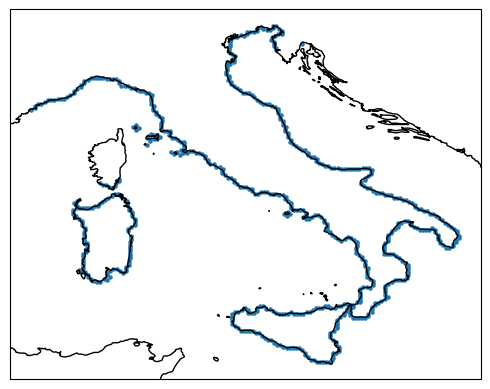

In [141]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree(), s=5)
ax.coastlines()
plt.show()

In [137]:
len(pset)

664

# Kernel creation
This should be pretty simple based on the flags above

In [138]:
kernels = create_kernel(fieldset, pset)
kernels

[<function kernels.PolyTEOS10_bsq(particle, fieldset, time)>,
 <function parcels.application_kernels.advection.AdvectionRK4_3D(particle, fieldset, time)>,
 <function kernels.biofouling(particle, fieldset, time)>,
 <function kernels.Stokes_drift(particle, fieldset, time)>,
 <function kernels.windage_drift(particle, fieldset, time)>,
 <function kernels.vertical_mixing(particle, fieldset, time)>]

In [139]:
len_kernels = len(kernels)

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


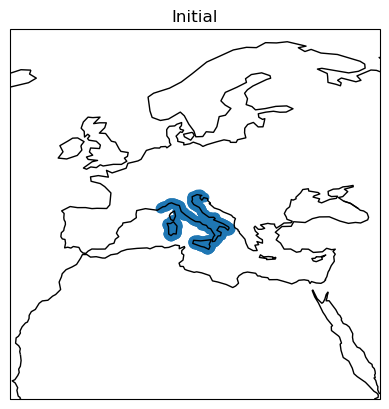

INFO: Compiled ArrayJITParticlePolyTEOS10_bsq ==> /var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/parcels-502/lib6178b73b068d74a3918e3d6c84c87eec_0.so
INFO: Output files are stored in ../../data/output_data/PolyTEOS10_bsq.zarr.
100%|██████████| 259200.0/259200.0 [00:15<00:00, 16283.20it/s]  
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


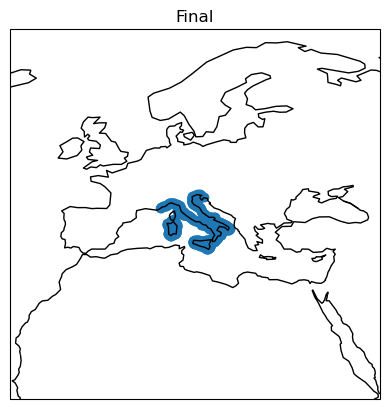

Success with PolyTEOS10_bsq


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


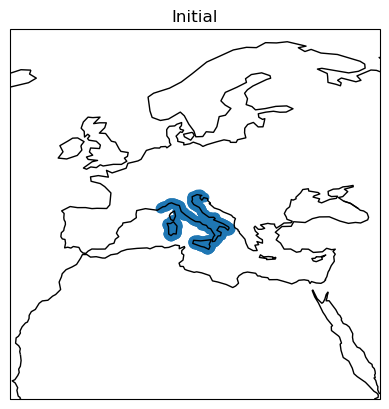

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/parcels-502/libb6734a116eba4a29339073c7931c0f70_0.so


Error with AdvectionRK4_3D
0
Particle P[17515047](lon=12.325885, lat=44.333639, depth=0.000000, settling_velocity=0.000000, absolute_salinity=0.000000, algae_amount=0.000000, particle_diameter=0.001000, particle_density=1032.000000, seawater_density=0.000000, windage_coefficient=0.010000, time=0.000000)
Time: 2019-01-09T12:00:00.000000000
timestep dt: 1200.0
Through-surface sampling by particle at (12.32588518401718, 44.33363898006486, 0.0)


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


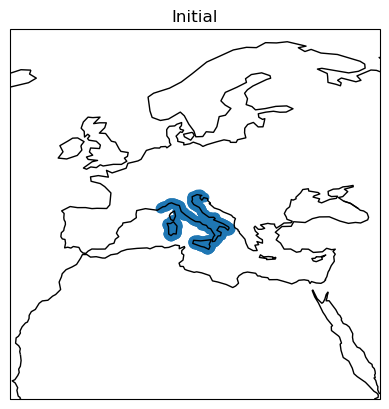

INFO: Compiled ArrayJITParticlebiofouling ==> /var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/parcels-502/libccca49d641bc14c7ac7c88c21096810c_0.so
INFO: Output files are stored in ../../data/output_data/biofouling.zarr.
100%|██████████| 259200.0/259200.0 [00:16<00:00, 15656.33it/s] 
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


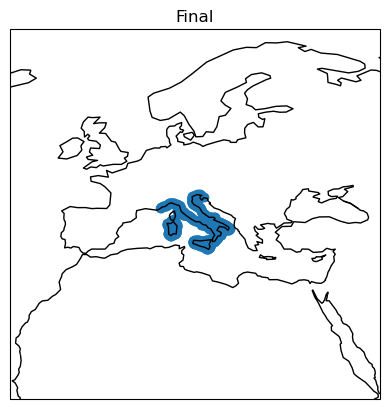

Success with biofouling


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


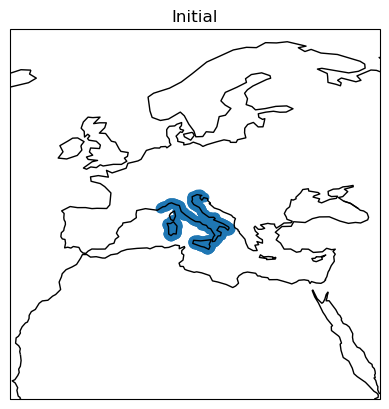

INFO: Compiled ArrayJITParticleStokes_drift ==> /var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/parcels-502/libe835f370f0bb5ff540896ea77e004f72_0.so
INFO: Output files are stored in ../../data/output_data/Stokes_drift.zarr.
100%|██████████| 259200.0/259200.0 [00:13<00:00, 19545.30it/s]
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


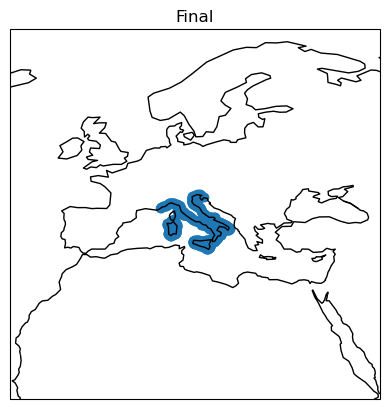

Success with Stokes_drift


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


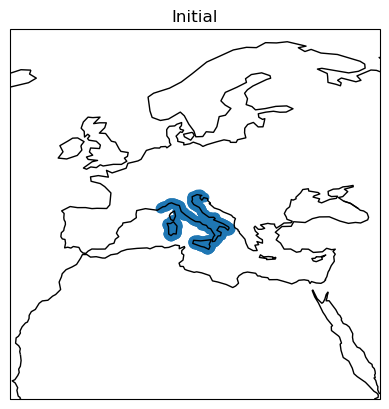

INFO: Compiled ArrayJITParticlewindage_drift ==> /var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/parcels-502/libf100bfacba44873f3acbc571314fb976_0.so
INFO: Output files are stored in ../../data/output_data/windage_drift.zarr.
100%|██████████| 259200.0/259200.0 [00:13<00:00, 19539.82it/s]
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


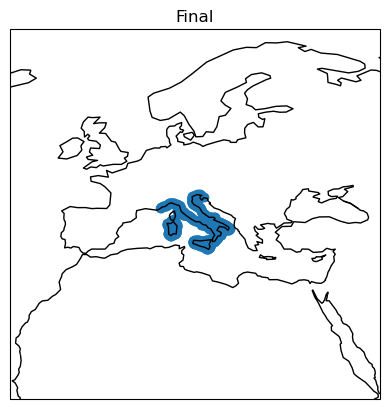

Success with windage_drift


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


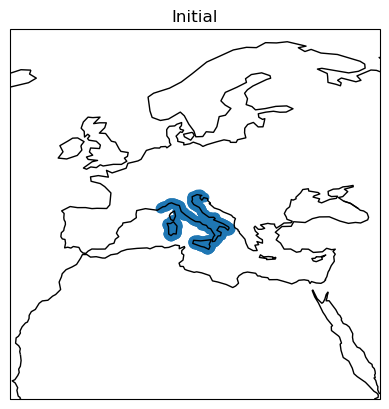

INFO: Compiled ArrayJITParticlevertical_mixing ==> /var/folders/40/_dzhm_n16gn9bfdpc_8tcpf00000gp/T/parcels-502/lib2aea326d0ddc9ceb6d2d0f5d9cac08cc_0.so
INFO: Output files are stored in ../../data/output_data/vertical_mixing.zarr.
100%|██████████| 259200.0/259200.0 [00:24<00:00, 10633.60it/s]
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


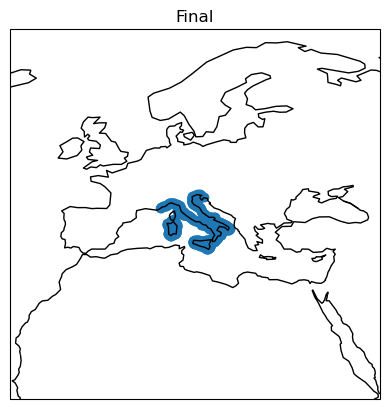

Success with vertical_mixing


In [140]:
for i in range(len_kernels):
    #Reset the particle set and kernels
    pset = create_particleset_from_file(fieldset, particle_settings)
    kernels = create_kernel(fieldset, pset)
    
    # Plot locations
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
    plt.title("Initial")
    plt.show()


    test_kernel=kernels[i]
    try:
        pfile = ParticleFile(user_settings['output_directory']+test_kernel.__name__+'.zarr', pset, outputdt=particle_settings['dt_write'])
        pset.execute(test_kernel, runtime=particle_settings['runtime'], dt=particle_settings['dt_timestep'], output_file=pfile)
        

        #Plot locations final
        fig = plt.figure()
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
        plt.title("Final")
        plt.show()
        print("Success with", test_kernel.__name__)

    except Exception as error:
        print("Error with", test_kernel.__name__)
        print(error)

In [12]:

# for test_kernel in kernels:
#     pfile = ParticleFile(user_settings['output_directory']+test_kernel.__name__+'.zarr', pset, outputdt=particle_settings['dt_write'])
#     pset.execute(test_kernel, runtime=particle_settings['runtime'], dt=particle_settings['dt_timestep'], output_file=pfile)
